In [7]:
import os
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from itertools import combinations

plt.style.use("ggplot")

# Config

In [2]:
class CFG:
    seed = 69
    is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
    
    if is_kaggle:
        data_wd = Path('/kaggle', 'input', 'optiver-trading-at-the-close')
    else:
        data_wd = Path.home() / '.data' / 'optiver-trading-at-the-close'

# Data

In [14]:
df = pd.read_csv(CFG.data_wd / 'train.csv')
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


Stopping here since I'm spending way too much time on this. Will revisit this later.

# Feature Engineering

In [15]:
prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

# V1
df["volume"] = df.eval("ask_size + bid_size")
df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
df["size_imbalance"] = df.eval("bid_size / ask_size")

for c in combinations(prices, 2):
    df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

# Train / Test Split

In [22]:
count_date_ids = df.date_id.nunique()
test_size = 0.1
split_day = round((1 - test_size) * count_date_ids)
split_day

433

In [29]:
train_mask = df.date_id < split_day
train, valid = df[train_mask], df[~train_mask]

In [30]:
train.date_id.nunique(), valid.date_id.nunique()

(433, 48)

In [31]:
mask = ~df.target.isna()
X_train = train.loc[mask, :].drop(['row_id', "time_id"], axis=1).copy()
y_train = X_train.pop('target')

X_valid = valid.loc[mask, :].drop(['row_id', "time_id"], axis=1).copy()
y_valid = X_valid.pop('target')

# Modeling

In [32]:
model = lgb.LGBMRegressor(
    random_state = CFG.seed, 
    objective = 'mae', 
    device_type = 'gpu'
)

model.fit(X_train, y_train)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8153
[LightGBM] [Info] Number of data points in the train set: 4709893, number of used features: 34
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature groups (161.70 MB) transferred to GPU in 0.097007 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.069737


LGBMRegressor(device_type='gpu', objective='mae', random_state=69)

In [33]:
train_mae = mean_absolute_error(model.predict(X_train), y_train)
print(f'Train MAE: {train_mae:,.4f}')

valid_mae = mean_absolute_error(model.predict(X_valid), y_valid)
print(f'Validation MAE: {valid_mae:,.4f}')

Train MAE: 6.3058
Validation MAE: 5.8676


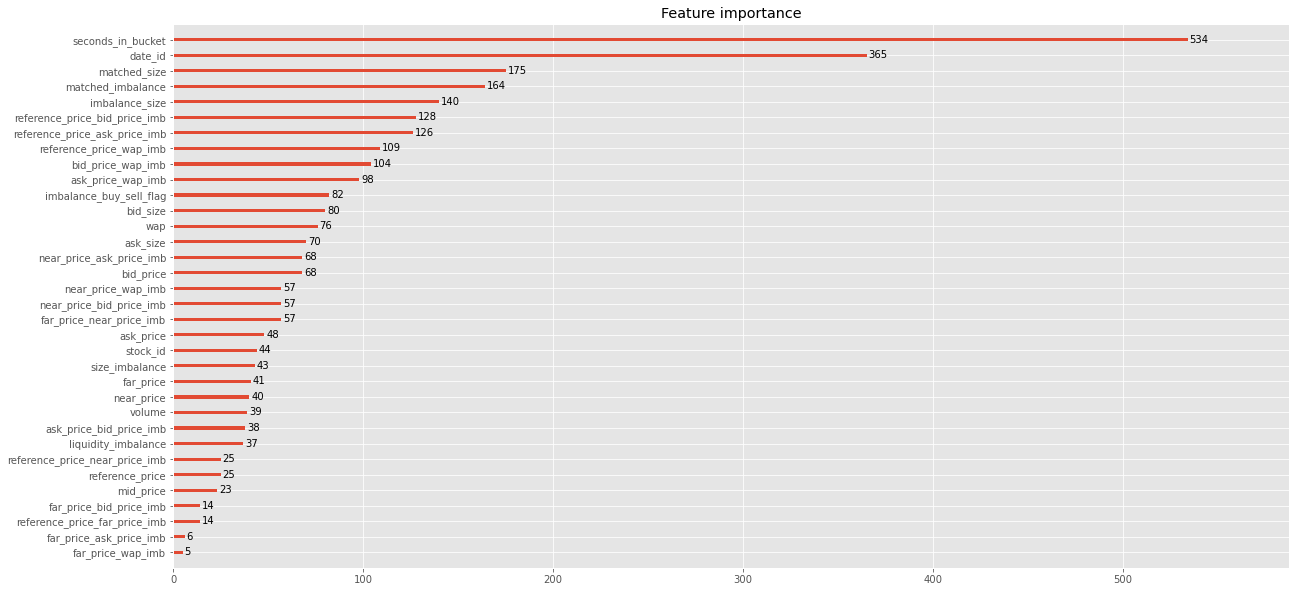

In [20]:
ax = lgb.plot_importance(
    model,
    figsize=(20, 10),
    xlabel='',
    ylabel='',
)
plt.show()

In [13]:
if CFG.is_kaggle:
    import optiver2023
    
    env = optiver2023.make_env()
    iter_test = env.iter_test()
    
    counter = 0
    for (test, revealed_targets, sample_prediction) in iter_test:
        sample_prediction['target'] = model.predict(test.drop(['row_id', 'currently_scored'], axis=1))
        env.predict(sample_prediction)
        counter += 1